## **3. Generative Tasks**
> Original Source: https://huggingface.co/docs/diffusers/v0.33.1/en/using-diffusers/unconditional_image_generation

```
> Unconditional Image Generation
> Text-guided Depth-to-image Generation
```

In [2]:
import os
import numpy as np
import torch
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import gc

from diffusers import DiffusionPipeline
from diffusers import StableDiffusionPipeline
from diffusers import ControlNetModel, AutoPipelineForText2Image, StableDiffusionDepth2ImgPipeline

from diffusers.utils import load_image, make_image_grid

----
### **Unconditional Image Generation**
- Unconditional image generation generates images that look like a random sample from the training data the model was trained on because the denoising process is not guided by any additional context like text or image.
- To get started, use the `DiffusionPipeline` to load the `anton-l/ddpm-butterflies-128` checkpoint to generate images of butterflies.
  - The `DiffusionPipeline` downloads and caches all the model components required to generate an image.

model_index.json:   0%|          | 0.00/181 [00:00<?, ?B/s]

C:\Users\USER\anaconda3\envs\diffusers-t2i\lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\USER\.cache\huggingface\hub\models--anton-l--ddpm-butterflies-128. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/455M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/852 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/289 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

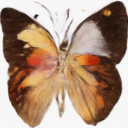

In [3]:
generator = DiffusionPipeline.from_pretrained("anton-l/ddpm-butterflies-128").to("cuda")
image = generator().images[0]
image

- You can also try experimenting with the `num_inference_steps` parameter, which controls the number of denoising steps.
  - **More denoising steps typically produce higher quality images**, but it’ll take longer to generate.
  - Feel free to play around with this parameter to see how it affects the image quality.

  0%|          | 0/100 [00:00<?, ?it/s]

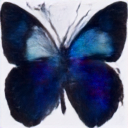

In [4]:
image = generator(num_inference_steps=100).images[0]
image

----
### **Text-to-Image**
- When you think of diffusion models, `text-to-image` is usually one of the first things that come to mind.
- `Text-to-image` generates an image from a text description which is also known as a prompt.

- A diffusion model takes a prompt and some random initial noise, and iteratively removes the noise to construct an image.
  - The denoising process is guided by the prompt, and once the denoising process ends after a predetermined number of time steps, the image representation is decoded into an image.
 
- You can generate images from a prompt in Diffusers in two steps:
  1. Load a checkpoint into the `AutoPipelineForText2Image` class, which automatically detects the appropriate pipeline class to use based on the checkpoint.
  2. Pass a prompt to the pipeline to generate an image.

In [ ]:
pipeline = AutoPipelineForText2Image.from_pretrained(
	"stable-diffusion-v1-5/stable-diffusion-v1-5", torch_dtype=torch.float16, variant="fp16"
).to("cuda")

In [ ]:
image = pipeline(
	"stained glass of darth vader, backlight, centered composition, masterpiece, photorealistic, 8k"
).images[0]
image

- **Popular models**
  - The most common `text-to-image` models are `Stable Diffusion v1.5`, `Stable Diffusion XL (SDXL)`, and `Kandinsky 2.2`.
  - There are also ControlNet models or adapters that can be used with `text-to-image` models for more direct control in generating images.

#### Stable Diffusion v1.5
- `Stable Diffusion v1.5` is a latent diffusion model initialized from `Stable Diffusion v1-4`, and finetuned for 595K steps on 512x512 images from the `LAION-Aesthetics V2` dataset.

In [ ]:
pipeline = AutoPipelineForText2Image.from_pretrained(
	"stable-diffusion-v1-5/stable-diffusion-v1-5", torch_dtype=torch.float16, variant="fp16"
).to("cuda")
generator = torch.Generator("cuda").manual_seed(31)
image = pipeline("Astronaut in a jungle, cold color palette, muted colors, detailed, 8k", generator=generator).images[0]
image

#### Stable Diffusion XL
- SDXL is a much larger version of the previous Stable Diffusion models, and involves a two-stage model process that adds even more details to an image.
  - It also includes some additional micro-conditionings to generate high-quality images centered subjects.
  - Take a look at the more comprehensive SDXL guide to learn more about how to use it.

In [ ]:
pipeline = AutoPipelineForText2Image.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16, variant="fp16"
).to("cuda")
generator = torch.Generator("cuda").manual_seed(31)
image = pipeline("Astronaut in a jungle, cold color palette, muted colors, detailed, 8k", generator=generator).images[0]
image

#### Kandinsky 2.2
- The Kandinsky model is a bit different from the Stable Diffusion models because it also uses an image prior model to create embeddings that are used to better align text and images in the diffusion model.

In [ ]:
pipeline = AutoPipelineForText2Image.from_pretrained(
	"kandinsky-community/kandinsky-2-2-decoder", torch_dtype=torch.float16
).to("cuda")
generator = torch.Generator("cuda").manual_seed(31)
image = pipeline("Astronaut in a jungle, cold color palette, muted colors, detailed, 8k", generator=generator).images[0]
image

#### ControlNet
- ControlNet models are auxiliary models or adapters that are finetuned on top of text-to-image models, such as `Stable Diffusion v1.5`.
  - Using ControlNet models in combination with `text-to-image` models offers diverse options for more explicit control over how to generate an image.
  - With ControlNet, you add an additional conditioning input image to the model.
    - ex. If you provide an image of a human pose (usually represented as multiple keypoints that are connected into a skeleton) as a **conditioning input**, the model generates an image that follows the pose of the image.
    - Check out the more in-depth ControlNet guide to learn more about other conditioning inputs and how to use them.

In [ ]:
controlnet = ControlNetModel.from_pretrained(
	"lllyasviel/control_v11p_sd15_openpose", torch_dtype=torch.float16, variant="fp16"
).to("cuda")
pose_image = load_image("https://huggingface.co/lllyasviel/control_v11p_sd15_openpose/resolve/main/images/control.png")

- Pass the controlnet to the `AutoPipelineForText2Image`, and provide the prompt and pose estimation image:

In [ ]:
pipeline = AutoPipelineForText2Image.from_pretrained(
	"stable-diffusion-v1-5/stable-diffusion-v1-5", controlnet=controlnet, torch_dtype=torch.float16, variant="fp16"
).to("cuda")
generator = torch.Generator("cuda").manual_seed(31)
image = pipeline("Astronaut in a jungle, cold color palette, muted colors, detailed, 8k", image=pose_image, generator=generator).images[0]
image

#### Configure pipeline parameters: Height and width
- There are a number of parameters that can be configured in the pipeline that affect how an image is generated. You can change the image’s output size, specify a negative prompt to improve image quality, and more. This section dives deeper into how to use these parameters.
- The **height and width** parameters control the height and width (in pixels) of the generated image.
  - By default, the `Stable Diffusion v1.5` model outputs 512x512 images, but you can change this to any size that is a multiple of 8.
  - SDXL’s default image size is 1024x1024 and using lower height and width values may result in lower quality images.

In [ ]:
# Create a rectangular image
pipeline = AutoPipelineForText2Image.from_pretrained(
	"stable-diffusion-v1-5/stable-diffusion-v1-5", torch_dtype=torch.float16, variant="fp16"
).to("cuda")
image = pipeline(
	"Astronaut in a jungle, cold color palette, muted colors, detailed, 8k", height=768, width=512
).images[0]
image

#### Configure pipeline parameters: Guidance scale
- The **guidance_scale** parameter affects how much the prompt influences image generation.
  - A lower value gives the model **creativity** to generate images that are more loosely related to the prompt.
  - Higher `guidance_scale` values push the model to follow the prompt more closely, and if this value is too high, you may observe some artifacts in the generated image.

In [ ]:
pipeline = AutoPipelineForText2Image.from_pretrained(
	"stable-diffusion-v1-5/stable-diffusion-v1-5", torch_dtype=torch.float16
).to("cuda")
image = pipeline(
	"Astronaut in a jungle, cold color palette, muted colors, detailed, 8k", guidance_scale=3.5
).images[0]
image

#### Configure pipeline parameters: Negative prompt
- Just like how a prompt guides generation, a negative prompt steers the model away from things you don’t want the model to generate.
  - This is commonly used to improve overall image quality by removing poor or bad image features such as “low resolution” or “bad details”.

In [ ]:
pipeline = AutoPipelineForText2Image.from_pretrained(
	"stable-diffusion-v1-5/stable-diffusion-v1-5", torch_dtype=torch.float16
).to("cuda")
image = pipeline(
	prompt="Astronaut in a jungle, cold color palette, muted colors, detailed, 8k",
	negative_prompt="ugly, deformed, disfigured, poor details, bad anatomy",
).images[0]
image

#### Configure pipeline parameters: Generator
- A `torch.Generator` object enables reproducibility in a pipeline by setting a manual seed.
  - Generate batches of images and iteratively improve on an image generated from a seed as detailed in the Improve image quality with deterministic generation guide.

In [ ]:
pipeline = AutoPipelineForText2Image.from_pretrained(
	"stable-diffusion-v1-5/stable-diffusion-v1-5", torch_dtype=torch.float16
).to("cuda")
generator = torch.Generator(device="cuda").manual_seed(30)
image = pipeline(
	"Astronaut in a jungle, cold color palette, muted colors, detailed, 8k",
	generator=generator,
).images[0]
image

#### Control image generation
- There are several ways to exert more control over how an image is generated outside of configuring a pipeline’s parameters, such as prompt weighting and ControlNet models.

- **Prompt weighting**
  - Prompt weighting is a technique for increasing or decreasing the importance of concepts in a prompt to emphasize or minimize certain features in an image.
  - We recommend using the Compel library to help you generate the weighted prompt embeddings.
  - Once you’ve created the embeddings, you can pass them to the prompt_embeds (and negative_prompt_embeds if you’re using a negative prompt) parameter in the pipeline.

In [ ]:
pipeline = AutoPipelineForText2Image.from_pretrained(
	"stable-diffusion-v1-5/stable-diffusion-v1-5", torch_dtype=torch.float16
).to("cuda")
image = pipeline(
	prompt_embeds=prompt_embeds, # generated from Compel
	negative_prompt_embeds=negative_prompt_embeds, # generated from Compel
).images[0]

- **ControlNet**
  - These models offer a more flexible and accurate way to generate images by incorporating an additional conditioning image input.
  - Each `ControlNet` model is pretrained on a particular type of conditioning image to generate new images that resemble it.
    - If you take a ControlNet model pretrained on depth maps, you can give the model a depth map as a conditioning input and it’ll generate an image that preserves the spatial information in it.
   
#### Optimize
- Diffusion models are large, and the iterative nature of denoising an image is computationally expensive and intensive.
  - But this doesn’t mean you need access to powerful - or even many - GPUs to use them.
  - You can load model weights in half-precision to save GPU memory and increase speed or offload the entire model to the GPU to save even more memory.

In [ ]:
pipeline = AutoPipelineForText2Image.from_pretrained("stable-diffusion-v1-5/stable-diffusion-v1-5", torch_dtype=torch.float16, variant="fp16").to("cuda")
pipeline.unet = torch.compile(pipeline.unet, mode="reduce-overhead", fullgraph=True)

---------------
### **Text-guided Depth-to-image Generation**
- The `StableDiffusionDepth2ImgPipeline` lets you pass a text prompt and an initial image to condition the generation of new images.
- You can also pass a `depth_map` to preserve the image structure.
  - If no `depth_map` is provided, the pipeline automatically predicts the depth via an integrated depth-estimation model.

In [ ]:
pipeline = StableDiffusionDepth2ImgPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-depth",
    torch_dtype=torch.float16,
    use_safetensors=True,
).to("cuda")

- Pass your prompt to the pipeline. 
  - You can also pass a `negative_prompt` to prevent certain words from guiding how an image is generated:

In [ ]:
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
init_image = load_image(url)
prompt = "two tigers"
negative_prompt = "bad, deformed, ugly, bad anatomy"
image = pipeline(prompt=prompt, image=init_image, negative_prompt=negative_prompt, strength=0.7).images[0]
make_image_grid([init_image, image], rows=1, cols=2)

  0%|          | 0/35 [00:00<?, ?it/s]